## 1. Decision Trees as Interpretable Models

Import packages

In [5]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree, _tree, export_text
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm 
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")


### (a) Obtain Data

Get the Accute Inamations Data Set

In [8]:
datapath = '../data/diagnosis.data'
data = pd.read_csv(datapath, encoding='utf-16', sep='\t', names=['Temperature','Nausea','Lumbar','Urine','Micturition','Urethra','Inflammation','Nephritis'], decimal=",")
data

,Temperature,Nausea,Lumbar,Urine,Micturition,Urethra,Inflammation,Nephritis
0,35.5,no,yes,no,no,no,no,no
1,35.9,no,no,yes,yes,yes,yes,no
2,35.9,no,yes,no,no,no,no,no
3,36.0,no,no,yes,yes,yes,yes,no
4,36.0,no,yes,no,no,no,no,no
...,...,...,...,...,...,...,...,...
115,41.4,no,yes,yes,no,yes,no,yes
116,41.5,no,no,no,no,no,no,no
117,41.5,yes,yes,no,yes,no,no,yes
118,41.5,no,yes,yes,no,yes,no,yes


### (b) Build a decision tree

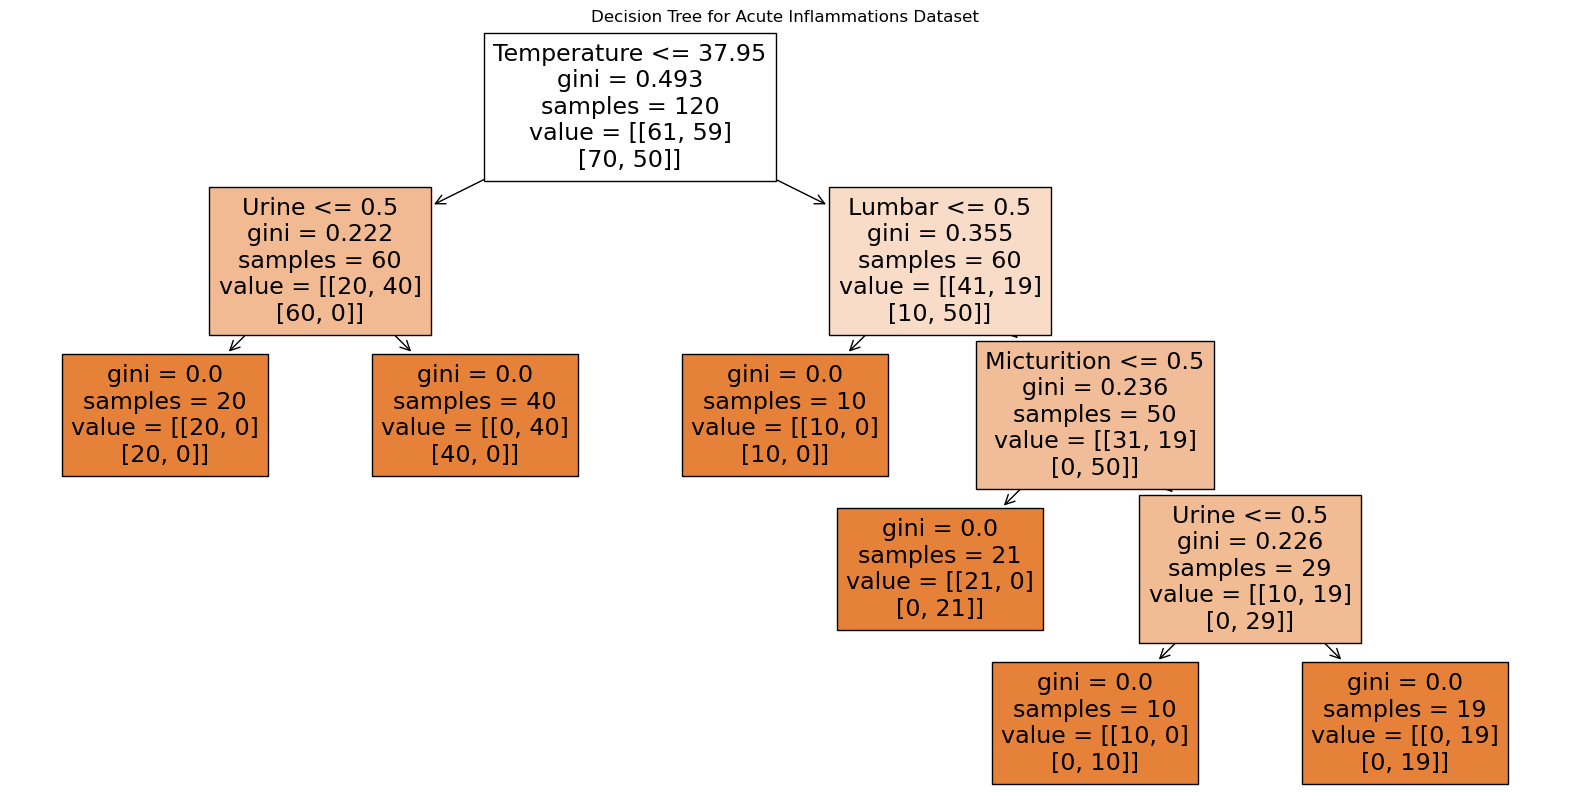

In [10]:
data = data.replace({'yes': 1, 'no': 0})

features = list(data.columns[:6])
targets = data.columns[-2:]

X = data[features]
y = data[targets]

tree = DecisionTreeClassifier(random_state=0)
tree.fit(X, y)

plt.figure(figsize=(20,10))
plot_tree(tree, feature_names=X.columns, class_names=['No', 'Yes'], filled=True)
plt.title("Decision Tree for Acute Inflammations Dataset")
plt.show()

### (c) Convert the decision rules

In [12]:
def tree_to_if_then(tree, feature_names, target_names=['No', 'Yes'], node=0, depth=0):
    """
    Recursively extracts decision rules from a trained decision tree.
    """
    indent = "    " * depth  
    tree_ = tree.tree_
    feature = tree_.feature[node]
    threshold = tree_.threshold[node]
    
    if tree_.children_left[node] == _tree.TREE_LEAF:
   
        class_name = target_names[int(tree_.value[node][0].argmax())]
        print(f"{indent}THEN Class = {class_name}")
    else:
        
        feature_name = feature_names[feature]
        print(f"{indent}IF ({feature_name} <= {threshold:.2f})")
        
        print(f"{indent}  ", end="")
        tree_to_if_then(tree, feature_names, target_names, tree_.children_left[node], depth + 1)
        
        print(f"{indent}ELSE (if {feature_name} > {threshold:.2f})")
        
        print(f"{indent}  ", end="")
        tree_to_if_then(tree, feature_names, target_names, tree_.children_right[node], depth + 1)

print("Rules for predicting 'Inflammation':")
tree_to_if_then(tree, features)



Rules for predicting 'Inflammation':
IF (Temperature <= 37.95)
      IF (Urine <= 0.50)
              THEN Class = No
    ELSE (if Urine > 0.50)
              THEN Class = Yes
ELSE (if Temperature > 37.95)
      IF (Lumbar <= 0.50)
              THEN Class = No
    ELSE (if Lumbar > 0.50)
              IF (Micturition <= 0.50)
                      THEN Class = No
        ELSE (if Micturition > 0.50)
                      IF (Urine <= 0.50)
                              THEN Class = No
            ELSE (if Urine > 0.50)
                              THEN Class = Yes


###  (d)

Optimal ccp_alpha selected: 0.0


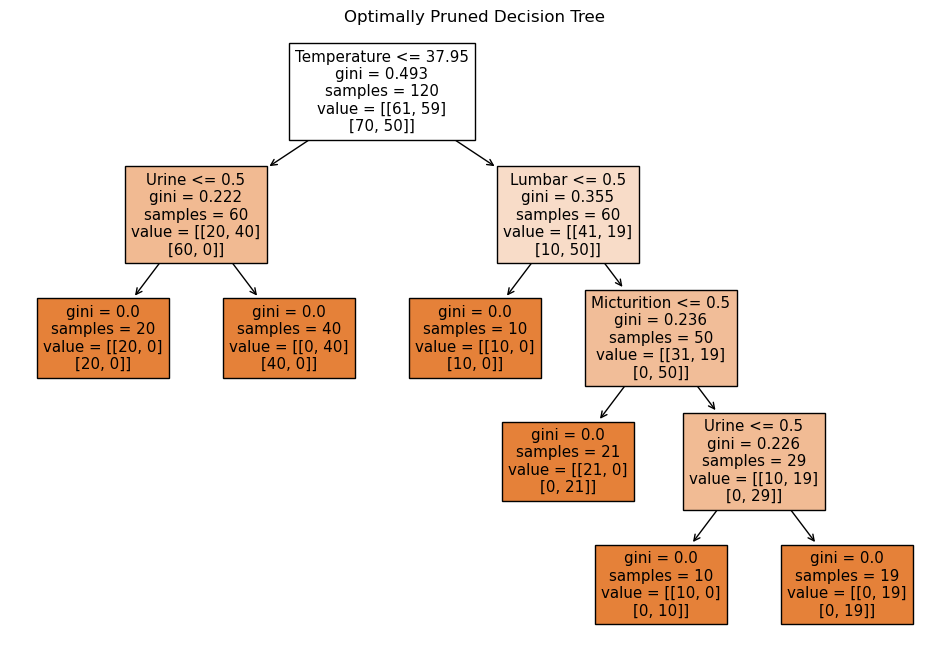

Decision Tree Rules:
Root & (Temperature <= 37.95) & (undefined <= 0.50) => Predict: 'Class 0'
Root & (Temperature <= 37.95) & (undefined > 0.50) => Predict: 'Class 1'
Root & (Temperature > 37.95) & (undefined <= 0.50) => Predict: 'Class 0'
Root & (Temperature > 37.95) & (undefined > 0.50) & (Lumbar <= 0.50) => Predict: 'Class 0'
Root & (Temperature > 37.95) & (undefined > 0.50) & (Lumbar > 0.50) & (undefined <= 0.50) => Predict: 'Class 0'
Root & (Temperature > 37.95) & (undefined > 0.50) & (Lumbar > 0.50) & (undefined > 0.50) => Predict: 'Class 1'


In [14]:
base_tree = DecisionTreeClassifier(random_state=69)
pruning_params = base_tree.cost_complexity_pruning_path(X, y)

alpha_list = pruning_params.ccp_alphas
impurity_list = pruning_params.impurities

alpha_performance = []
for alpha in alpha_list:
    model = DecisionTreeClassifier(random_state=69, ccp_alpha=alpha)
    cv_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
    alpha_performance.append((alpha, cv_scores.mean()))

selected_alpha, highest_score = max(alpha_performance, key=lambda x: x[1])
print("Optimal ccp_alpha selected:", selected_alpha)

final_tree = DecisionTreeClassifier(random_state=69, ccp_alpha=selected_alpha)
final_tree.fit(X, y)

plt.figure(figsize=(12, 8))
plot_tree(final_tree, filled=True, feature_names=X.columns, class_names=['Class 0', 'Class 1'])
plt.title('Optimally Pruned Decision Tree')
plt.show()

def generate_tree_rules(decision_tree, feature_names, class_labels):
    """
    Display the decision rules of a decision tree by traversing nodes.
    """
    tree_structure = decision_tree.tree_
    feature_names_with_undefined = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined"
        for i in tree_structure.feature
    ]

    
    nodes = [(0, "Root")]  
    rules = []

    while nodes:
        node_id, description = nodes.pop()
        feature_index = tree_structure.feature[node_id]
        
      
        if feature_index != _tree.TREE_UNDEFINED:  
            feature_name = feature_names_with_undefined[feature_index]
            threshold = tree_structure.threshold[node_id]

            
            left_desc = f"{description} & ({feature_name} <= {threshold:.2f})"
            right_desc = f"{description} & ({feature_name} > {threshold:.2f})"
            nodes.append((tree_structure.children_right[node_id], right_desc))
            nodes.append((tree_structure.children_left[node_id], left_desc))
        else:  
            prediction = class_labels[tree_structure.value[node_id][0].argmax()]
            rules.append(f"{description} => Predict: '{prediction}'")

    print("Decision Tree Rules:")
    for rule in rules:
        print(rule)



generate_tree_rules(final_tree, feature_names=X.columns, class_labels=['Class 0', 'Class 1'])


## 2. The LASSO and Boosting for Regression

### (a) Obtain Data

In [17]:
datapath = '../data/communities.data'
dataframe = pd.read_csv(datapath, names=['state','county','community','communityname','fold','population','householdsize','racepctblack','racePctWhite','racePctAsian','racePctHisp','agePct12t21','agePct12t29','agePct16t24','agePct65up','numbUrban','pctUrban','medIncome','pctWWage','pctWFarmSelf','pctWInvInc','pctWSocSec','pctWPubAsst','pctWRetire','medFamInc','perCapInc','whitePerCap','blackPerCap','indianPerCap','AsianPerCap','OtherPerCap','HispPerCap','NumUnderPov','PctPopUnderPov','PctLess9thGrade','PctNotHSGrad','PctBSorMore','PctUnemployed','PctEmploy','PctEmplManu','PctEmplProfServ','PctOccupManu','PctOccupMgmtProf','MalePctDivorce','MalePctNevMarr','FemalePctDiv','TotalPctDiv','PersPerFam','PctFam2Par','PctKids2Par','PctYoungKids2Par','PctTeen2Par','PctWorkMomYoungKids','PctWorkMom','NumIlleg','PctIlleg','NumImmig','PctImmigRecent','PctImmigRec5','PctImmigRec8','PctImmigRec10','PctRecentImmig','PctRecImmig5','PctRecImmig8','PctRecImmig10','PctSpeakEnglOnly','PctNotSpeakEnglWell','PctLargHouseFam','PctLargHouseOccup','PersPerOccupHous','PersPerOwnOccHous','PersPerRentOccHous','PctPersOwnOccup','PctPersDenseHous','PctHousLess3BR','MedNumBR','HousVacant','PctHousOccup','PctHousOwnOcc','PctVacantBoarded','PctVacMore6Mos','MedYrHousBuilt','PctHousNoPhone','PctWOFullPlumb','OwnOccLowQuart','OwnOccMedVal','OwnOccHiQuart','RentLowQ','RentMedian','RentHighQ','MedRent','MedRentPctHousInc','MedOwnCostPctInc','MedOwnCostPctIncNoMtg','NumInShelters','NumStreet','PctForeignBorn','PctBornSameState','PctSameHouse85','PctSameCity85','PctSameState85','LemasSwornFT','LemasSwFTPerPop','LemasSwFTFieldOps','LemasSwFTFieldPerPop','LemasTotalReq','LemasTotReqPerPop','PolicReqPerOffic','PolicPerPop','RacialMatchCommPol','PctPolicWhite','PctPolicBlack','PctPolicHisp','PctPolicAsian','PctPolicMinor','OfficAssgnDrugUnits','NumKindsDrugsSeiz','PolicAveOTWorked','LandArea','PopDens','PctUsePubTrans','PolicCars','PolicOperBudg','LemasPctPolicOnPatr','LemasGangUnitDeploy','LemasPctOfficDrugUn','PolicBudgPerPop','ViolentCrimesPerPop'], na_values="?")
df_train = dataframe[:1495]
df_test = dataframe[1495:]

### (b) Missing values

In [19]:
train_data = df_train.iloc[:, 5:]
test_data = df_test.iloc[:, 5:]

imputer = SimpleImputer(strategy='mean')

train_data_imputed = pd.DataFrame(imputer.fit_transform(train_data), columns=train_data.columns)
test_data_imputed = pd.DataFrame(imputer.transform(test_data), columns=test_data.columns)

print(f"Size of training dataset after imputation: {train_data_imputed.shape}")
print(f"Size of testing dataset after imputation: {test_data_imputed.shape}")

Size of training dataset after imputation: (1495, 123)
Size of testing dataset after imputation: (499, 123)


### (c) Plot a correlation matrix

In [21]:
combined_data = pd.concat([df_train, df_test], ignore_index=True)

numeric_data = combined_data.select_dtypes(include=[np.number])

correlation_matrix = numeric_data.corr()

styled_corr_matrix = correlation_matrix.style.background_gradient(cmap='viridis')

styled_corr_matrix

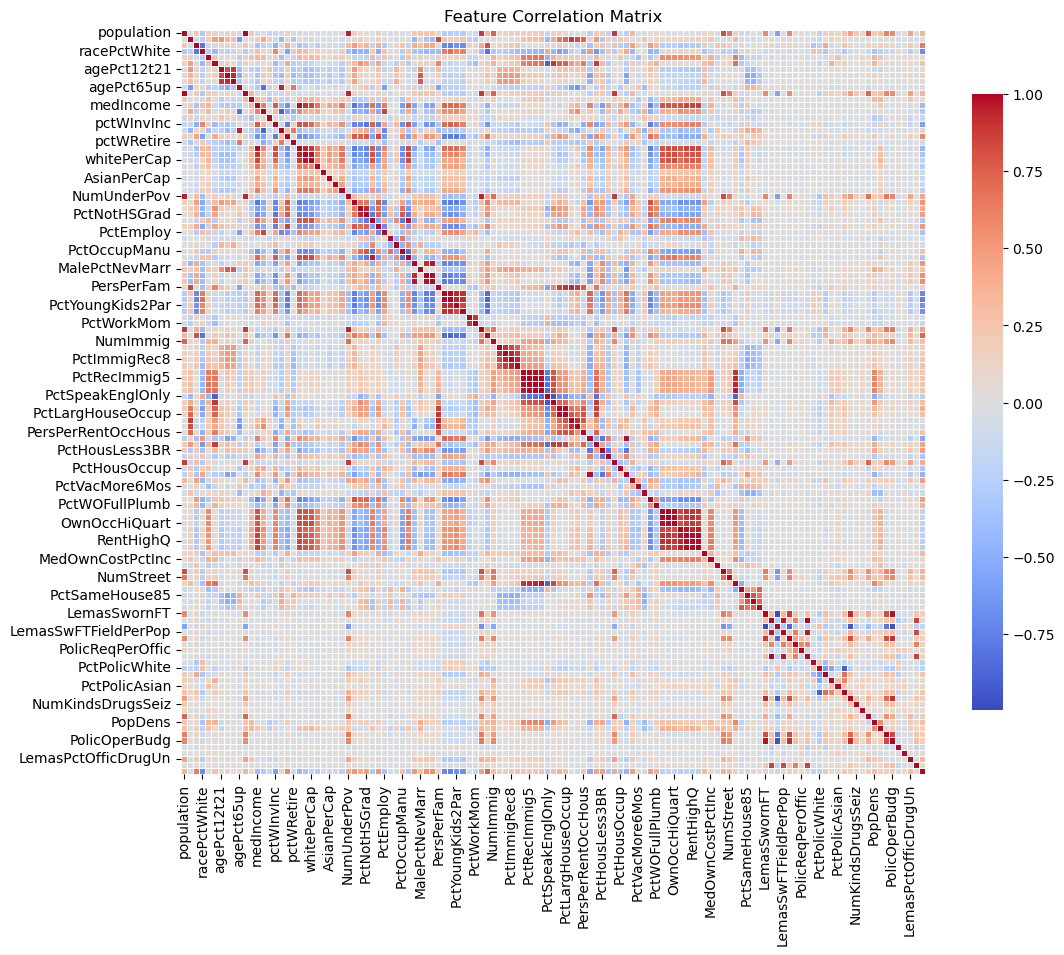

In [22]:
correlation_matrix = train_data_imputed.corr()

plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, 
            linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title("Feature Correlation Matrix")
plt.show()

### (d) Calculate the Coefficient of Variation CV

In [24]:
feature_means = numeric_data.mean()
feature_std_dev = numeric_data.std()

cv = feature_std_dev / feature_means

cv_df = pd.DataFrame(cv, columns=['Coefficient of Variation'])
print(cv_df)


                     Coefficient of Variation
state                                0.571671
county                               2.149029
community                            0.547751
fold                                 0.523062
population                           2.203503
...                                       ...
LemasPctPolicOnPatr                  0.306251
LemasGangUnitDeploy                  0.921372
LemasPctOfficDrugUn                  2.555266
PolicBudgPerPop                      0.844368
ViolentCrimesPerPop                  0.979015

[127 rows x 1 columns]


### (e) Scatter plots and box plots for highest CV features

In [26]:
num_top_features = int(np.sqrt(128))

top_cv_features = cv.nlargest(num_top_features)

print(top_cv_features)

NumStreet              4.407702
NumInShelters          3.485481
NumIlleg               2.994196
NumImmig               2.900497
LemasPctOfficDrugUn    2.555266
NumUnderPov            2.304970
population             2.203503
county                 2.149029
numbUrban              2.001744
LemasSwornFT           1.984599
PctPolicAsian          1.979371
dtype: float64


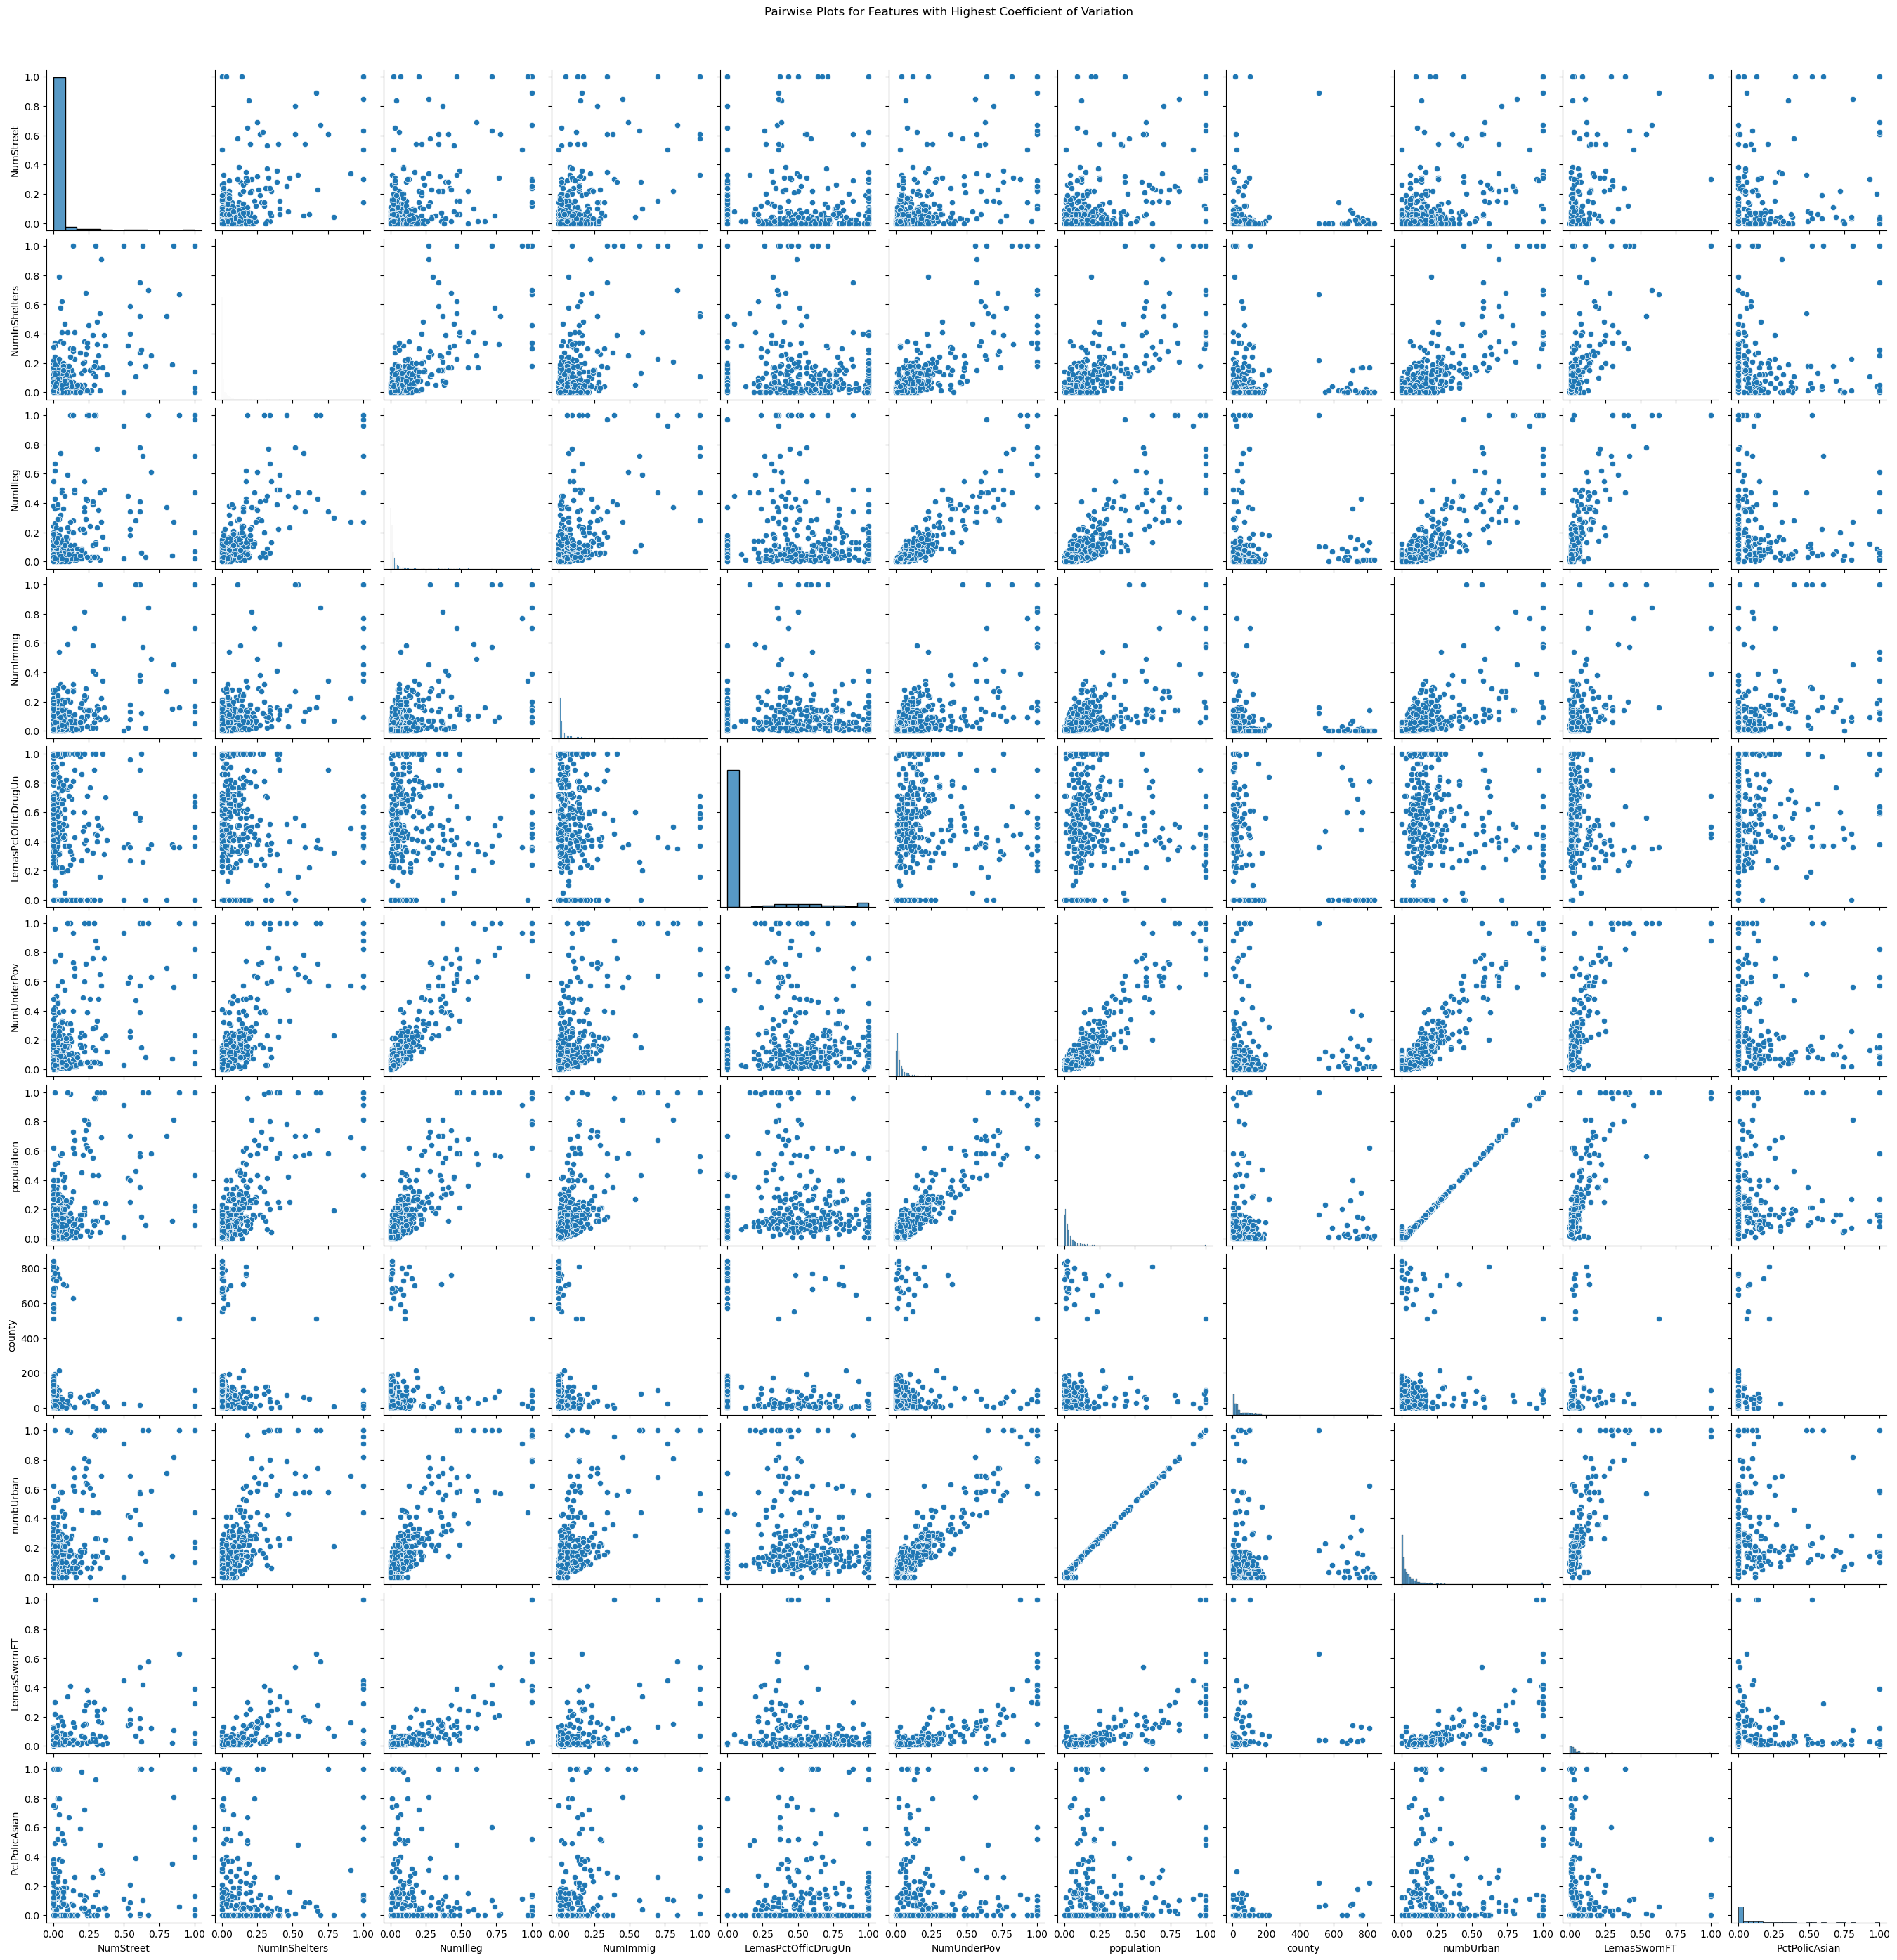

In [27]:
selected_features = top_cv_features.index.tolist()

sns.pairplot(data=combined_data[selected_features])
plt.suptitle("Pairwise Plots for Features with Highest Coefficient of Variation", y=1.02)
plt.show()

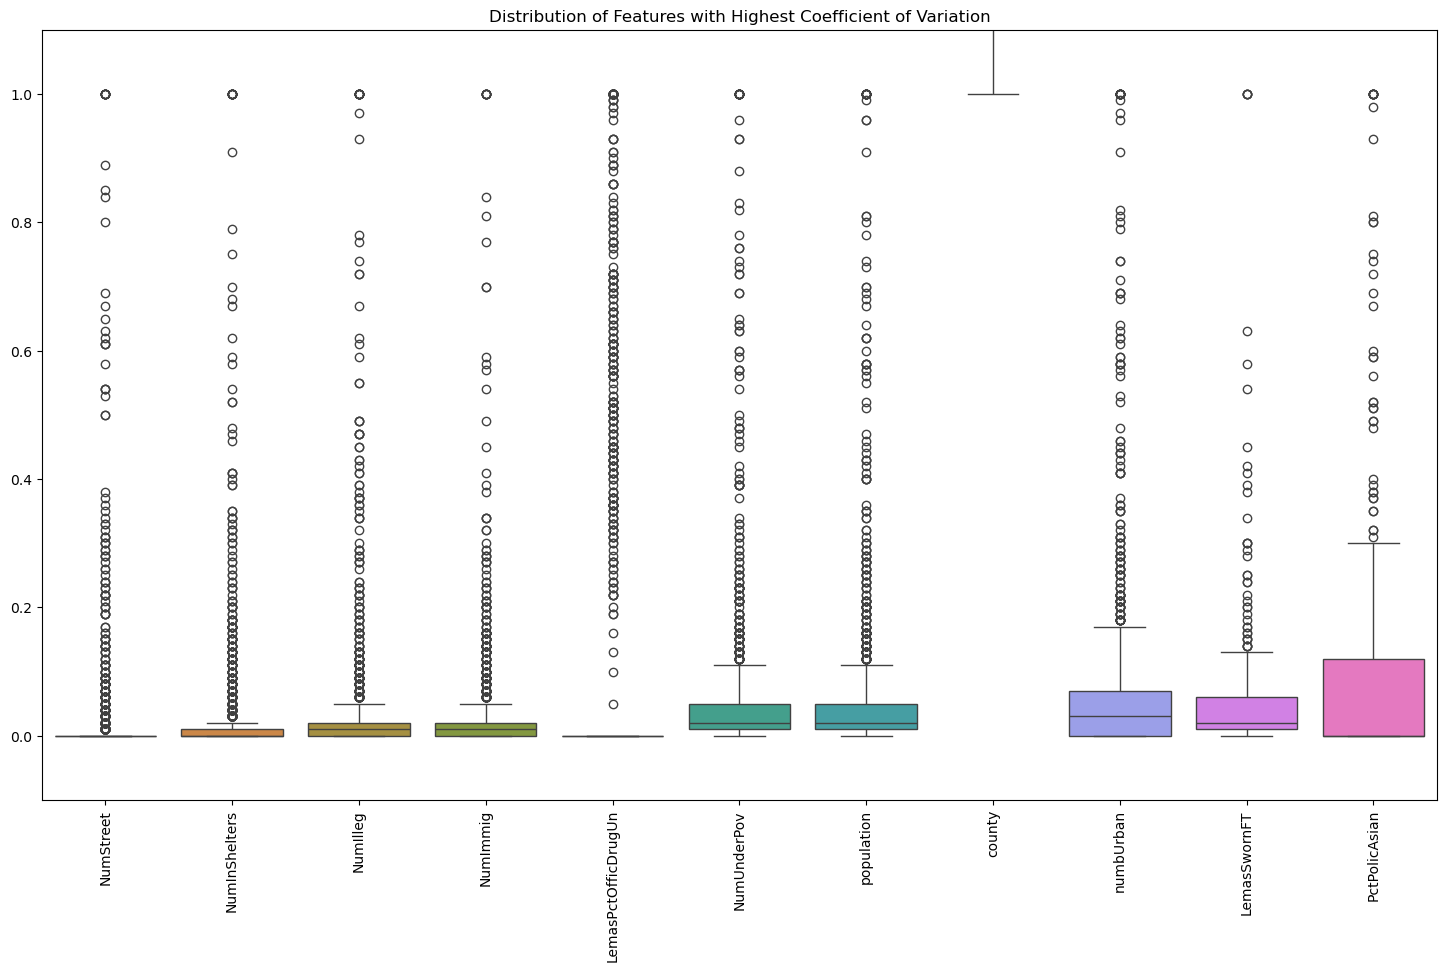

In [28]:
selected_top_features = list(top_cv_features.index)

plt.figure(figsize=(18, 10))
sns.boxplot(data=combined_data[selected_top_features], orient='v')

plt.title('Distribution of Features with Highest Coefficient of Variation')
plt.xticks(rotation=90)
plt.ylim(-0.1, 1.1)  # Adjust y-axis limits as needed
plt.show()

According to the above scatter and box plots, the coefficient of variation between variables `NumStreet` and `LemasPctOfficDrugUn` is very low, which may improve accuracy.


However, relying on scatter plots alone will be insufficient to arrive at a definitive conclusion. Other analyses would be needed to get more substantial evidence before any concrete conclusion is reached.

### (f) Fit a linear model

In [31]:
X_train = train_data_imputed.iloc[:, :-1]  
y_train = train_data_imputed.iloc[:, -1]    
X_test = test_data_imputed.iloc[:, :-1]
y_test = test_data_imputed.iloc[:, -1]

X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

linear_model = sm.OLS(y_train, X_train_const).fit()

predicted_test = linear_model.predict(X_test_const)

mse_test = mean_squared_error(y_test, predicted_test)
print("Test Set Mean Squared Error (MSE):", round(mse_test, 5))


Test Set Mean Squared Error (MSE): 0.01814


### (g) Fit a ridge regression model

In [33]:
cross_val = KFold(n_splits=5, shuffle=True, random_state=50)

ridge_regressor = RidgeCV(cv=cross_val)
ridge_regressor.fit(X_train,y_train)

test_predictions = ridge_regressor.predict(X_train)

test_mse = mean_squared_error(y_train, test_predictions)

print("Optimal Alpha (Lambda) from Cross-Validation:", ridge_regressor.alpha_)
print("Test Mean Squared Error (MSE) with Ridge Regression:", round(test_mse, 5))

Optimal Alpha (Lambda) from Cross-Validation: 1.0
Test Mean Squared Error (MSE) with Ridge Regression: 0.01669


### (h) Fit a LASSO model

In [35]:
def execute_lasso(X_train, y_train, X_test, y_test, apply_scaling=False):
    important_features = []

    if apply_scaling:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        X_train, X_test = pd.DataFrame(X_train_scaled, columns=X_train.columns), pd.DataFrame(X_test_scaled, columns=X_test.columns)

    cv_strategy = KFold(n_splits=5, shuffle=True, random_state=50)
    
    lasso_model = LassoCV(cv=cv_strategy, random_state=50)
    lasso_model.fit(X_train, y_train)

    predictions = lasso_model.predict(X_test)
    
    important_features = [
        (feature, coef) for feature, coef in zip(X_train.columns, lasso_model.coef_) if coef != 0
    ]
    
    optimal_alpha = lasso_model.alpha_
    mse_test = mean_squared_error(y_test, predictions)
    
    return optimal_alpha, mse_test, important_features

In [36]:
alpha_no_scaling, mse_no_scaling, features_no_scaling = execute_lasso(X_train, y_train, X_test, y_test, apply_scaling=False)
print("Optimal alpha without scaling:", alpha_no_scaling)
print("Test MSE without scaling:", mse_no_scaling)
print("Number of selected features without scaling:", len(features_no_scaling))
print("Selected features without scaling:")
features_no_scaling

Optimal alpha without scaling: 9.421060424823112e-05
Test MSE without scaling: 0.017798679823706903
Number of selected features without scaling: 78
Selected features without scaling:


[('racepctblack', 0.27339565215121264),
 ('racePctAsian', -0.018675340792319813),
 ('agePct12t21', 0.0790330038053242),
 ('agePct12t29', -0.30005946369372016),
 ('agePct65up', 0.005874478335867452),
 ('pctUrban', 0.04121588729265737),
 ('pctWWage', -0.09621516487475017),
 ('pctWFarmSelf', 0.02999147522667148),
 ('pctWInvInc', -0.11446327312435621),
 ('pctWSocSec', 0.06248285967928936),
 ('pctWPubAsst', 0.043196865532899135),
 ('pctWRetire', -0.11028468782489474),
 ('whitePerCap', -0.07374673344489062),
 ('blackPerCap', -0.02311802269330309),
 ('indianPerCap', -0.03223159747940767),
 ('AsianPerCap', 0.02933063017739972),
 ('OtherPerCap', 0.024019511001171952),
 ('HispPerCap', 0.02622555791716099),
 ('PctPopUnderPov', -0.15368755744835233),
 ('PctLess9thGrade', -0.022307225000511636),
 ('PctBSorMore', 0.023939212283316386),
 ('PctEmploy', 0.16138079048997273),
 ('PctEmplManu', -0.02049309060529158),
 ('PctOccupManu', 0.018995480901955415),
 ('MalePctDivorce', 0.13794150863654095),
 ('Mal

In [37]:
alpha_with_scaling, mse_with_scaling, features_with_scaling = execute_lasso(X_train, y_train, X_test, y_test, apply_scaling=True)
print("\nOptimal alpha with scaling:", alpha_with_scaling)
print("Test MSE with scaling:", mse_with_scaling)
print("Number of selected features with scaling:", len(features_with_scaling))
print("Selected features with scaling:")
features_with_scaling


Optimal alpha with scaling: 0.0007116541214377484
Test MSE with scaling: 0.017821603142236235
Number of selected features with scaling: 73
Selected features with scaling:


[('racepctblack', 0.06858870925793548),
 ('racePctAsian', -0.001360628476772045),
 ('agePct12t21', 0.011291618767082671),
 ('agePct12t29', -0.04022167456759961),
 ('pctUrban', 0.016802473042178186),
 ('pctWWage', -0.013003159360660405),
 ('pctWFarmSelf', 0.004377856493284314),
 ('pctWInvInc', -0.021216410951677686),
 ('pctWSocSec', 0.009385458078625303),
 ('pctWPubAsst', 0.006704066693141961),
 ('pctWRetire', -0.01750392150278842),
 ('whitePerCap', -0.009487391421876514),
 ('blackPerCap', -0.0037525679590309498),
 ('indianPerCap', -0.005283808296876053),
 ('AsianPerCap', 0.00538214087592416),
 ('OtherPerCap', 0.0038952119702655133),
 ('HispPerCap', 0.004205662721913283),
 ('PctPopUnderPov', -0.027938158086610432),
 ('PctLess9thGrade', -0.0025347261648514183),
 ('PctEmploy', 0.02265654343113571),
 ('PctEmplManu', -0.0012749096237330262),
 ('MalePctDivorce', 0.019941068973786665),
 ('MalePctNevMarr', 0.022100135698349677),
 ('FemalePctDiv', -0.011719460251362092),
 ('PctKids2Par', -0.040

### (i) Fit a PCR model

In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

max_components = min(X_train.shape[0], X_train.shape[1])
mse_scores = []

for m in range(1, max_components + 1):
    
    pca = PCA(n_components=m)
    X_train_pca = pca.fit_transform(X_train_scaled)
    
    model = LinearRegression()
    scores = cross_val_score(model, X_train_pca, y_train, cv=5, scoring='neg_mean_squared_error')
    
    mse_scores.append(-np.mean(scores))

optimal_m = np.argmin(mse_scores) + 1 
print(f"Optimal number of components (M) obtained using cross-validation: {optimal_m}")

pca_final = PCA(n_components=optimal_m)
X_train_pca_final = pca_final.fit_transform(X_train_scaled)
X_test_pca_final = pca_final.transform(X_test_scaled)

final_model = LinearRegression()
final_model.fit(X_train_pca_final, y_train)

y_train_pred = final_model.predict(X_train_pca_final)
train_mse = mean_squared_error(y_train, y_train_pred)
print("Train Mean Squared Error (MSE) with PCR:", round(train_mse, 5))

y_test_pred = final_model.predict(X_test_pca_final)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Test Mean Squared Error (MSE) with PCR:", round(test_mse, 5))

Optimal number of components (M) obtained using cross-validation: 95
Train Mean Squared Error (MSE) with PCR: 0.01665
Test Mean Squared Error (MSE) with PCR: 0.01839


### (j) Fit a boosting tree

In [41]:
def select_best_alpha(X_train, y_train):
    alpha_range = list(range(0, 11))
    alpha_mse = {alpha: 0 for alpha in alpha_range}
    
    for alpha in alpha_range:
        model = XGBRegressor(reg_alpha=alpha, random_state=42)
        cv_mse = cross_val_score(
            model, X_train, y_train, 
            cv=KFold(n_splits=5, shuffle=True, random_state=42), 
            scoring='neg_mean_squared_error'
        )
        alpha_mse[alpha] = np.abs(cv_mse).mean()  
    
    optimal_alpha = min(alpha_mse, key=alpha_mse.get)
    best_mse_score = alpha_mse[optimal_alpha]
    return optimal_alpha, best_mse_score

chosen_alpha, training_mse = select_best_alpha(X_train, y_train)
print("Optimal alpha selected via cross-validation:", chosen_alpha)
print("Mean Squared Error (MSE) on training set with optimal alpha:", training_mse)

def assess_xgboost_performance(alpha_value, X_train, y_train, X_test, y_test):

    model = XGBRegressor(reg_alpha=alpha_value, random_state=42)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    test_set_mse = mean_squared_error(y_test, predictions)
    return test_set_mse

test_mse_value = assess_xgboost_performance(chosen_alpha, X_train, y_train, X_test, y_test)
print("Mean Squared Error (MSE) on test data with optimal alpha:", test_mse_value)

Optimal alpha selected via cross-validation: 5
Mean Squared Error (MSE) on training set with optimal alpha: 0.020897794376897958
Mean Squared Error (MSE) on test data with optimal alpha: 0.016269179073479568


References-
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html
https://scikit-learn.org/stable/modules/tree.html
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
https://scikit-learn.org/stable/auto_examples/tree/index.html
https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html
https://mljar.com/blog/extract-rules-decision-tree/
https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html
https://scikit-learn.org/stable/modules/cross_validation.html
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.select_dtypes.html
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html#Background-gradient
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.index.html
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Index.tolist.html
https://seaborn.pydata.org/generated/seaborn.pairplot.html
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.suptitle.html
https://seaborn.pydata.org/generated/seaborn.boxplot.html
https://www.geeksforgeeks.org/matplotlib-pyplot-title-in-python/
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.ylim.html
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html
https://www.statsmodels.org/stable/generated/statsmodels.tools.add_constant.html
https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html
https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor
https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.cross_val_score.html



